In [1]:
import torch

In [2]:
device = torch.device('cuda:0') if torch.cuda.is_available else torch.device('cpu')
device

device(type='cuda', index=0)

In [3]:
from torchvision.datasets import MNIST
import torchvision.transforms as tfs

In [4]:
data_tfs = tfs.Compose([
  tfs.ToTensor(),
  tfs.Normalize((0.5), (0.5))
])

In [5]:
# install for train and test
root = './'
train = MNIST(root, train=True,  transform=data_tfs, download=True)
test  = MNIST(root, train=False, transform=data_tfs, download=True)

In [6]:
print(f'Data size:\n\t train {len(train)},\n\t test {len(test)}')
print(f'Data shape:\n\t features {train[0][0].shape},\n\t target {type(test[0][1])}')

Data size:
	 train 60000,
	 test 10000
Data shape:
	 features torch.Size([1, 28, 28]),
	 target <class 'int'>


In [7]:
from torch.utils.data import DataLoader

batch_size = 128

train_loader = DataLoader(train, batch_size=batch_size, drop_last=True)
test_loader = DataLoader(test, batch_size=batch_size, drop_last=True)

In [8]:
x_batch, y_batch = next(iter(train_loader))
x_batch.shape, y_batch.shape

(torch.Size([128, 1, 28, 28]), torch.Size([128]))

In [9]:
features = 784
classes = 10

In [10]:
W = torch.FloatTensor(features, classes).uniform_(-1, 1) / features**0.5
W.requires_grad_()

tensor([[ 0.0007,  0.0130, -0.0061,  ...,  0.0259,  0.0032,  0.0172],
        [-0.0300,  0.0134, -0.0295,  ...,  0.0343,  0.0181, -0.0236],
        [-0.0326, -0.0292, -0.0253,  ...,  0.0076,  0.0320, -0.0021],
        ...,
        [ 0.0083,  0.0058,  0.0105,  ...,  0.0273, -0.0036,  0.0029],
        [-0.0175, -0.0133, -0.0274,  ...,  0.0343, -0.0135, -0.0010],
        [ 0.0275, -0.0212, -0.0259,  ...,  0.0123,  0.0164,  0.0320]],
       requires_grad=True)

In [11]:
epochs = 3
lr = 1e-2
history = []

In [12]:
import numpy as np
from torch.nn.functional import cross_entropy

In [13]:
for i in range(epochs):
  for x_batch, y_batch in train_loader:
    x_batch = x_batch.reshape(x_batch.shape[0], -1)

    # compute loss (log loss a.k.a. cross entropy)
    logits = x_batch @ W
    probabilities = torch.exp(logits) / torch.exp(logits).sum(dim=1, keepdims=True)
    
    loss = -torch.log(probabilities[range(batch_size), y_batch]).mean()
    history.append(loss.item())

    # calc gradients
    loss.backward()

    # step of gradient descent
    grad = W.grad
    with torch.no_grad():
      W -= lr * grad
    W.grad.zero_()

  print(f'{i+1},\t loss: {history[-1]}')

1,	 loss: 0.1998634934425354
2,	 loss: 0.14378497004508972
3,	 loss: 0.12313871085643768


In [14]:
import matplotlib.pyplot as plt

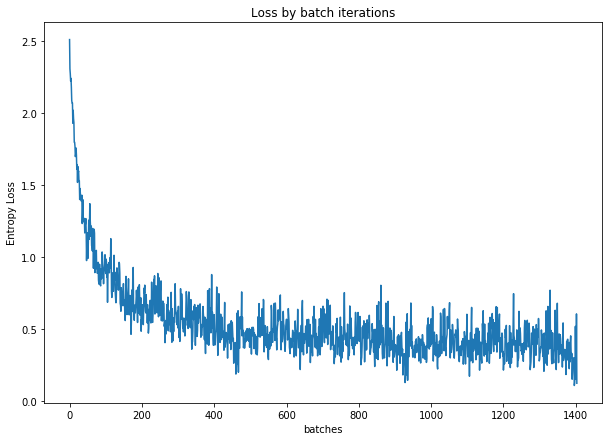

In [15]:
plt.figure(figsize=(10, 7))

plt.plot(history)

plt.title('Loss by batch iterations')
plt.ylabel('Entropy Loss')
plt.xlabel('batches')

plt.show()

In [16]:
from sklearn.metrics import accuracy_score

In [17]:
acc = 0
batches = 0

for x_batch, y_batch in test_loader:
  batches += 1
  x_batch = x_batch.view(x_batch.shape[0], -1)
  y_batch = y_batch

  preds = torch.argmax(x_batch @ W, dim=1)
  acc += (preds==y_batch).cpu().numpy().mean()

print(f'Test accuracy {acc / batches:.3}')

Test accuracy 0.9


In [18]:
import torch.nn as nn
from torchsummary import summary

In [19]:
model = nn.Sequential(
  nn.Linear(features, 64),
  nn.ReLU(),
  nn.Linear(64, classes)
)


model

Sequential(
  (0): Linear(in_features=784, out_features=64, bias=True)
  (1): ReLU()
  (2): Linear(in_features=64, out_features=10, bias=True)
)

In [20]:
summary(model, (features,), batch_size=228)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [228, 64]          50,240
              ReLU-2                  [228, 64]               0
            Linear-3                  [228, 10]             650
Total params: 50,890
Trainable params: 50,890
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.68
Forward/backward pass size (MB): 0.24
Params size (MB): 0.19
Estimated Total Size (MB): 1.12
----------------------------------------------------------------


In [21]:
criterion = nn.CrossEntropyLoss()      

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, betas=(0.9, 0.99))

In [22]:
epochs = 3
history = []

In [23]:
for i in range(epochs):
  for x_batch, y_batch in train_loader:
    x_batch = x_batch.view(x_batch.shape[0], -1)
    y_batch = y_batch

    logits = model(x_batch)

    # compute loss
    loss = criterion(logits, y_batch)
    history.append(loss.item())

    #  calc gradients
    optimizer.zero_grad()
    loss.backward()

    # step of gradient descent
    optimizer.step()

  print(f'{i+1},\t loss: {history[-1]}')

1,	 loss: 0.0829484686255455
2,	 loss: 0.055976688861846924
3,	 loss: 0.040594689548015594


In [24]:
import matplotlib.pyplot as plt

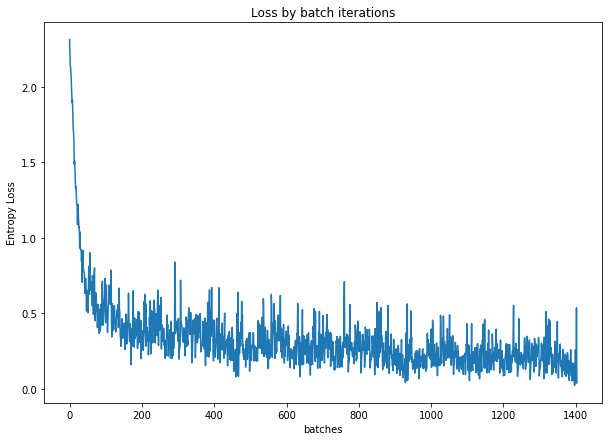

In [25]:
plt.figure(figsize=(10, 7))

plt.plot(history)

plt.title('Loss by batch iterations')
plt.ylabel('Entropy Loss')
plt.xlabel('batches')

plt.show()

In [26]:
from sklearn.metrics import accuracy_score

In [27]:
acc = 0
batches = 0

for x_batch, y_batch in test_loader:
  batches += 1
  x_batch = x_batch.view(x_batch.shape[0], -1)
  y_batch = y_batch

  preds = torch.argmax(model(x_batch), dim=1)
  acc += (preds==y_batch).cpu().numpy().mean()

print(f'Test accuracy {acc / batches:.3}')

Test accuracy 0.94
